In [1]:
# !pip install gym torch numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 8.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827730 sha256=f6a7e790e5689ed4d78674266e0d82f25d2adb2906d987c591ab0e8cdb82df6b
  Stored in directory: /Users/virenvarma/Library/Caches/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym


In [6]:
# !pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.2 MB/s eta 0:00:00a 0:00:01


Episode 1, Reward: -1272.30
Episode 2, Reward: -1588.08
Episode 3, Reward: -1806.39
Episode 4, Reward: -1677.77
Episode 5, Reward: -1670.23
Episode 6, Reward: -1544.66
Episode 7, Reward: -1626.25
Episode 8, Reward: -1607.68
Episode 9, Reward: -1385.73
Episode 10, Reward: -1376.96
Episode 11, Reward: -1438.03
Episode 12, Reward: -1402.45
Episode 13, Reward: -1390.65
Episode 14, Reward: -723.39
Episode 15, Reward: -1149.67
Episode 16, Reward: -758.31
Episode 17, Reward: -1119.44
Episode 18, Reward: -1052.85
Episode 19, Reward: -1356.53
Episode 20, Reward: -1248.42
Episode 21, Reward: -1250.72
Episode 22, Reward: -1205.37
Episode 23, Reward: -1304.51
Episode 24, Reward: -1211.37
Episode 25, Reward: -1241.25
Episode 26, Reward: -1195.63
Episode 27, Reward: -1138.26
Episode 28, Reward: -1111.37
Episode 29, Reward: -1110.23
Episode 30, Reward: -1152.27
Episode 31, Reward: -1160.97
Episode 32, Reward: -1140.98
Episode 33, Reward: -1058.48
Episode 34, Reward: -935.08
Episode 35, Reward: -905.5

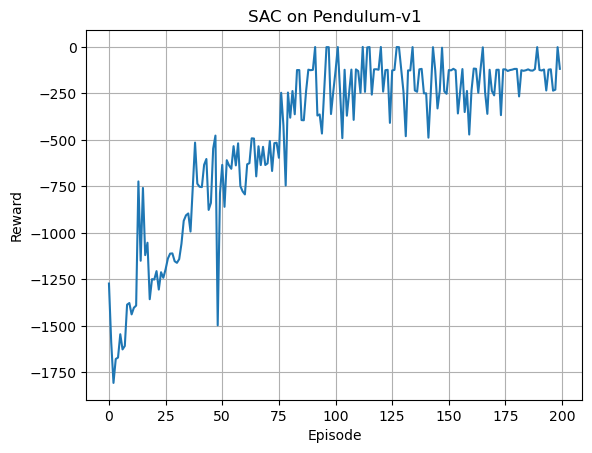

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
import matplotlib.pyplot as plt

# Hyperparameters
LR = 3e-4
GAMMA = 0.99
TAU = 0.005
ALPHA = 0.2  # Entropy coefficient
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 256
ENV_NAME = "Pendulum-v1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=BUFFER_SIZE):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, BATCH_SIZE)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(states).to(device),
            torch.FloatTensor(actions).to(device),
            torch.FloatTensor(rewards).unsqueeze(1).to(device),
            torch.FloatTensor(next_states).to(device),
            torch.FloatTensor(dones).unsqueeze(1).to(device)
        )

    def __len__(self):
        return len(self.buffer)

# Actor Network
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)

    def forward(self, state):
        x = self.net(state)
        mean = self.mean(x)
        log_std = torch.clamp(self.log_std(x), -20, 2)
        std = log_std.exp()
        return mean, std

    def sample(self, state):
        mean, std = self.forward(state)
        normal = torch.distributions.Normal(mean, std)
        z = normal.rsample()
        action = torch.tanh(z)
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-7)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action * max_action, log_prob

# Critic Network (Q-function)
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.q1 = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        self.q2 = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=-1)
        return self.q1(sa), self.q2(sa)

# Soft Actor-Critic Agent
class SACAgent:
    def __init__(self):
        self.actor = Actor().to(device)
        self.critic = Critic().to(device)
        self.critic_target = Critic().to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=LR)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=LR)

        self.replay_buffer = ReplayBuffer()

    def update(self):
        if len(self.replay_buffer) < BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        # Critic loss
        with torch.no_grad():
            next_actions, next_log_probs = self.actor.sample(next_states)
            q1_target, q2_target = self.critic_target(next_states, next_actions)
            min_q_target = torch.min(q1_target, q2_target) - ALPHA * next_log_probs
            target_q = rewards + GAMMA * (1 - dones) * min_q_target

        q1, q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(q1, target_q) + F.mse_loss(q2, target_q)

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        # Actor loss
        actions_pi, log_probs = self.actor.sample(states)
        q1_pi, q2_pi = self.critic(states, actions_pi)
        min_q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (ALPHA * log_probs - min_q_pi).mean()

        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        # Soft update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

# Training Loop
agent = SACAgent()
episodes = 200
rewards_history = []

for ep in range(episodes):
    state, _ = env.reset()
    state = np.asarray(state, dtype=np.float32)
    total_reward = 0
    for step in range(200):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, _ = agent.actor.sample(state_tensor)
        action_np = action.detach().cpu().numpy()[0]

        next_state, reward, terminated, truncated, _ = env.step(action_np)
        done = terminated or truncated
        next_state = np.asarray(next_state, dtype=np.float32)

        agent.replay_buffer.add(state, action_np, reward, next_state, done)
        agent.update()

        state = next_state
        total_reward += reward
        if done:
            break
    rewards_history.append(total_reward)
    print(f"Episode {ep+1}, Reward: {total_reward:.2f}")

# Plotting
plt.plot(rewards_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("SAC on Pendulum-v1")
plt.grid(True)
plt.show()


In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Create a new environment for rendering
env_vis = gym.make(ENV_NAME, render_mode="rgb_array")

frames = []
state, _ = env_vis.reset()
state = np.asarray(state, dtype=np.float32)

for _ in range(200):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    action, _ = agent.actor.sample(state_tensor)
    action_np = action.detach().cpu().numpy()[0]

    frame = env_vis.render()  # Get RGB frame
    frames.append(frame)

    next_state, reward, terminated, truncated, _ = env_vis.step(action_np)
    done = terminated or truncated
    state = np.asarray(next_state, dtype=np.float32)

    if done:
        break

env_vis.close()

# Create an animation
fig = plt.figure(figsize=(6,6))
plt.axis('off')
im = plt.imshow(frames[0])

def update(frame):
    im.set_data(frame)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=frames, interval=50)
plt.close()

# If using Jupyter Notebook
HTML(ani.to_jshtml())


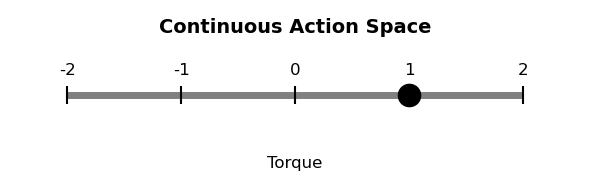

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Slider range
min_torque = -2
max_torque = 2
selected_torque = 1.0  # Example current action

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 2))
ax.set_xlim(min_torque - 0.5, max_torque + 0.5)
ax.set_ylim(0, 1)
ax.axis('off')

# Draw slider line
ax.hlines(0.5, min_torque, max_torque, color='gray', linewidth=5)

# Draw tick marks and labels
for tick in np.linspace(min_torque, max_torque, 5):
    ax.vlines(tick, 0.45, 0.55, color='black')
    ax.text(tick, 0.6, f"{tick:.0f}", ha='center', va='bottom', fontsize=12)

# Draw slider knob
ax.plot(selected_torque, 0.5, 'ko', markersize=16)

# Add labels
ax.text(0, 0.9, "Continuous Action Space", ha='center', va='center', fontsize=14, weight='bold')
ax.text(0, 0.1, "Torque", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()


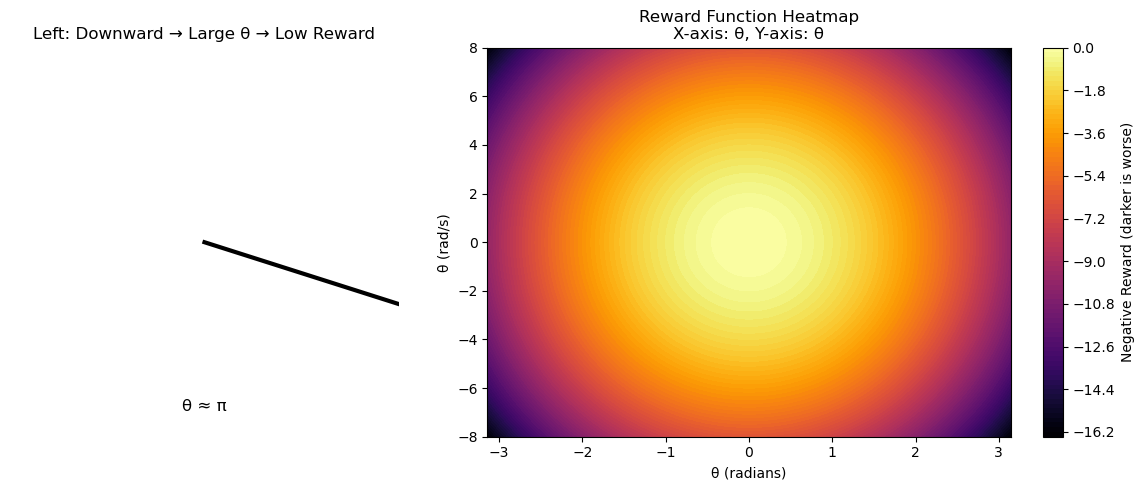

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Define the reward function
def reward(theta, theta_dot, torque=0):
    return -(theta**2 + 0.1 * theta_dot**2 + 0.001 * torque**2)

# Create meshgrid for θ and θ̇
theta_vals = np.linspace(-np.pi, np.pi, 300)
theta_dot_vals = np.linspace(-8, 8, 300)
Theta, Theta_dot = np.meshgrid(theta_vals, theta_dot_vals)

# Compute rewards with torque = 0 (for visualization)
Reward = reward(Theta, Theta_dot, torque=0)

# Setup side-by-side plot
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5])

# Left: Downward pendulum
ax0 = plt.subplot(gs[0])
ax0.set_title("Left: Downward → Large θ → Low Reward")
ax0.plot([0, np.pi], [0, -1], 'k-', lw=3)  # Pendulum pointing downward
ax0.set_xlim(-1.5, 1.5)
ax0.set_ylim(-1.5, 1.5)
ax0.set_aspect('equal')
ax0.axis('off')
ax0.text(0, -1.3, "θ ≈ π", ha='center', fontsize=12)

# Right: Heatmap of reward
ax1 = plt.subplot(gs[1])
c = ax1.contourf(Theta, Theta_dot, Reward, levels=100, cmap='inferno')
ax1.set_title("Reward Function Heatmap\nX-axis: θ, Y-axis: θ̇")
ax1.set_xlabel("θ (radians)")
ax1.set_ylabel("θ̇ (rad/s)")
fig.colorbar(c, ax=ax1, label="Negative Reward (darker is worse)")

plt.tight_layout()
plt.show()

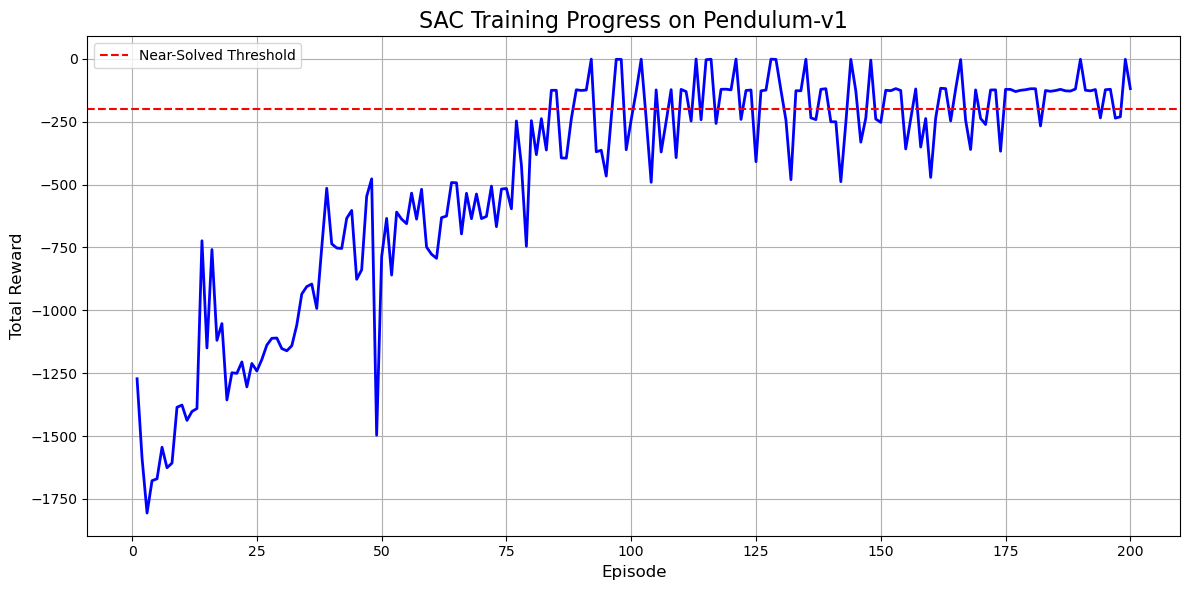

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
rewards = [
    -1272.30, -1588.08, -1806.39, -1677.77, -1670.23, -1544.66, -1626.25, -1607.68, -1385.73, -1376.96,
    -1438.03, -1402.45, -1390.65, -723.39, -1149.67, -758.31, -1119.44, -1052.85, -1356.53, -1248.42,
    -1250.72, -1205.37, -1304.51, -1211.37, -1241.25, -1195.63, -1138.26, -1111.37, -1110.23, -1152.27,
    -1160.97, -1140.98, -1058.48, -935.08, -905.58, -895.51, -992.73, -750.42, -514.60, -735.55,
    -752.01, -753.98, -633.94, -602.76, -876.59, -838.76, -546.81, -477.00, -1496.86, -787.16,
    -634.42, -859.77, -609.18, -637.28, -655.41, -533.89, -637.15, -518.56, -748.53, -776.96,
    -793.16, -631.38, -625.06, -491.69, -492.80, -696.19, -534.43, -635.50, -537.34, -635.13,
    -626.38, -506.08, -667.28, -517.58, -515.43, -596.16, -246.80, -421.32, -745.28, -245.54,
    -380.78, -237.49, -362.39, -124.69, -124.86, -393.77, -394.60, -238.13, -122.64, -125.47,
    -123.69, -0.91, -369.11, -363.52, -466.01, -236.11, -1.48, -1.75, -361.14, -241.45,
    -129.56, -1.10, -237.64, -490.72, -123.19, -370.09, -249.08, -122.23, -392.54, -121.12,
    -129.95, -247.04, -0.39, -241.85, -3.02, -1.18, -256.79, -120.84, -120.32, -123.05,
    -0.75, -240.60, -125.46, -123.57, -408.64, -126.93, -123.84, -0.90, -1.78, -124.34,
    -243.24, -480.30, -126.43, -126.63, -1.36, -234.34, -241.41, -120.77, -118.44, -249.97,
    -249.90, -488.22, -253.57, -1.85, -127.03, -331.06, -235.44, -4.63, -239.06, -252.35,
    -124.61, -126.44, -118.05, -125.58, -358.05, -239.88, -119.40, -350.46, -237.13, -471.21,
    -235.28, -116.67, -118.08, -246.47, -120.30, -2.64, -243.63, -360.19, -123.16, -236.57,
    -260.87, -123.53, -123.01, -367.10, -120.87, -121.19, -129.72, -124.87, -122.49, -118.61,
    -118.55, -266.46, -125.66, -128.77, -125.78, -120.96, -126.91, -127.85, -119.63, -1.50,
    -124.58, -127.01, -121.79, -234.50, -122.55, -120.61, -235.47, -230.08, -1.60, -118.12
]

episodes = list(range(1, len(rewards) + 1))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(episodes, rewards, color='blue', linewidth=2)
plt.title("SAC Training Progress on Pendulum-v1", fontsize=16)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.axhline(y=-200, color='red', linestyle='--', label='Near-Solved Threshold')
plt.legend()

plt.savefig("sac_pendulum_rewards.png")
plt.show()
